# Multi-modal RAG with LangChain

## SetUp

Install the dependencies you need to run the notebook.

In [7]:
# for linux
#%sudo apt-get install poppler-utils tesseract-ocr libmagic-dev
!apt-get update && apt-get install -y poppler-utils tesseract-ocr libmagic-dev
# for mac
# %brew install poppler tesseract libmagic

zsh:1: command not found: apt-get


In [8]:
%pip install -Uq "unstructured[all-docs]" pillow lxml pillow
%pip install -Uq chromadb tiktoken
%pip install -Uq langchain langchain-community langchain-openai langchain-groq
%pip install -Uq python_dotenv


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
from dotenv import load_dotenv

load_dotenv()

True

In [10]:
import os

# keys for the services we will use

os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
os.environ["GROQ_API_KEY"] = os.getenv('GROQ_API_KEY')
os.environ["LANGCHAIN_API_KEY"] = os.getenv('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"


## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc.

### Partition PDF tables, text, and images

In [11]:
import nltk

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /Users/kamal/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [12]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/kamal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [14]:
from unstructured.partition.pdf import partition_pdf

file_path = '/Users/kamal/Desktop/AgenticAI/Uploads/Attention Is All You Need.pdf'

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    image_output_dir_path=None,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
)

CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, def

In [15]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [16]:
len(chunks)

12

In [17]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

chunks[10]

In [18]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[3].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': '0b4db006-126c-4646-9805-98c63757ad0b',
 'text': '',
 'metadata': {'coordinates': {'points': ((486.0, 261.1805555555558),
    (486.0, 614.7805555555556),
    (664.0, 614.7805555555556),
    (664.0, 261.1805555555558)),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2025-05-28T22:04:49',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 4,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFiALIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQE

### Separate extracted elements into tables, text, and images

In [19]:
# separate texts
texts = []

for chunk in chunks:
      if "CompositeElement" in str(type((chunk))):
          texts.append(chunk)

In [20]:
texts

In [21]:
# Get the Tables from the CompositeElement objects
def get_tables(chunks):
    tables = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Table" in str(type(el)):
                    print("table found")
                    tables.append(el)
                    print(el.metadata.text_as_html)

    return tables

tables = get_tables(chunks)

table found
<table><thead><tr><th>Layer Type</th><th>Complexity per Layer</th><th>Sequential Operations</th><th>Maximum Path Length</th></tr></thead><tbody><tr><td>Self-Attention</td><td>O(n? - d)</td><td>O(1)</td><td>O(1)</td></tr><tr><td>Recurrent</td><td>O(n - d?)</td><td>O(n)</td><td>O(n)</td></tr><tr><td>Convolutional</td><td>O(k-n-d?)</td><td>O(1)</td><td>O(logx(n))</td></tr><tr><td>Self-Attention (restricted)</td><td>O(r-n-d)</td><td>ol)</td><td>O(n/r)</td></tr></tbody></table>
table found
<table><thead><tr><th>Model</th><th>EN-DE</th><th>EN-FR</th><th>Training EN-DE</th><th>EN-FR</th></tr></thead><tbody><tr><td colspan="5">ByteNet [18] 23.75</td></tr><tr><td>Deep-Att + PosUnk</td><td></td><td>39.2</td><td></td><td>1.0 - 107°</td></tr><tr><td>GNMT + RL 8]</td><td>24.6</td><td>39.92</td><td>2.3-10!9</td><td>1.4. 1070</td></tr><tr><td>ConvS28S [9]</td><td>25.16</td><td>40.46</td><td>9.6-10'%</td><td>1.5-1070</td></tr><tr><td>MoE</td><td>26.03</td><td>40.56</td><td>2.0-10'9</td><td

In [22]:
len(tables)

4

In [23]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

In [24]:
len(images)

7

#### Check what the images look like

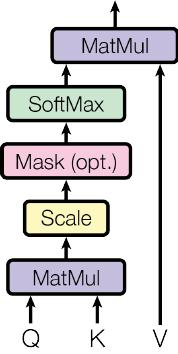

In [25]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[1])

## Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

### Text and Table summaries

We don't need a multimodal model to generate the summaries of the tables and the text. I will use open source models available on Groq.

In [26]:
%pip install -Uq langchain-groq

Note: you may need to restart the kernel to use updated packages.


In [27]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [28]:
from langchain_openai import ChatOpenAI

In [29]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
#model = ChatGroq(temperature=0.5, model="llama-3.3-70b-versatile")
model = ChatOpenAI(model="gpt-4o-mini")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [30]:
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

In [31]:
text_summaries

['The authors propose a novel network architecture called the Transformer, focused on attention mechanisms, which eliminates the need for recurrent and convolutional layers. Their experiments in machine translation demonstrate significant improvements in performance, achieving a BLEU score of 28.4 for English-to-German and a state-of-the-art score of 41.8 for English-to-French translations after relatively short training times. The Transformer also adapts well to other tasks, such as English constituency parsing. Several contributors from Google Brain and Google Research played key roles in its development, with equal contributions noted among the authors.',
 'Recurrent neural networks (RNNs), including long short-term memory and gated recurrent neural networks, are prominent in sequence modeling but face limitations due to their sequential computation. Attention mechanisms help model dependencies across sequences, often in conjunction with RNNs. The proposed Transformer model eliminat

In [32]:
# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [33]:
table_summaries

['The table compares different layer types in terms of their complexity, sequential operations, and maximum path length. Self-Attention has a complexity of O(n? - d), with constant sequential operations and a maximum path length of O(1). Recurrent layers have a complexity of O(n - d?), with linear sequential operations and a maximum path length of O(n). Convolutional layers feature complexity O(k-n-d?), constant sequential operations, and a logarithmic maximum path length O(logx(n)). Restricted Self-Attention shows complexity O(r-n-d), with sequential operations noted as "ol" and a maximum path length of O(n/r).',
 'The table presents various models along with their performance metrics in English to German (EN-DE) and English to French (EN-FR) translations. Key results include: \n\n- ByteNet: 23.75 (no EN-FR score)\n- Deep-Att + PosUnk: EN-FR 39.2\n- GNMT + RL: EN-DE 24.6, EN-FR 39.92\n- ConvS2S: EN-DE 25.16, EN-FR 40.46\n- MoE: EN-DE 26.03, EN-FR 40.56\n- Deep-Att + PosUnk Ensemble: E

### Image summaries

We will use gpt-4o-mini to produce the image summaries.

In [34]:
%pip install -Uq langchain_openai

Note: you may need to restart the kernel to use updated packages.


In [35]:
from langchain_openai import ChatOpenAI

prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()


image_summaries = chain.batch(images)

In [36]:
image_summaries

['The image depicts a diagram illustrating the architecture of Transformers, which is crucial for understanding how this model functions in processing sequences.\n\n1. **Structure Overview**:\n   - The diagram is divided into two main vertical sections: the Encoder (left side) and the Decoder (right side). Both components consist of stacked layers, denoted by "Nx," indicating that each section can be repeated N times.\n\n2. **Encoder Section**:\n   - At the top, there are inputs entering the encoder, which includes: \n     - **Input Embedding**: This is where the raw input data is transformed into a vector representation.\n     - **Positional Encoding**: A process to inject information about the position of tokens within the sequence, helping the model to understand the order.\n\n3. **Encoder Layers**:\n   - Each layer in the encoder contains:\n     - **Multi-Head Attention**: This component allows the model to focus on different parts of the input sequence simultaneously.\n     - **Ad

In [37]:
print(image_summaries[1])

The image presents a flowchart detailing a component of the transformer architecture commonly used in natural language processing. Here's a breakdown of its elements:

1. **Nodes**: Each rectangular node represents a different operation or transformation in the architecture. The nodes are color-coded to visually differentiate between the functions.

2. **MatMul Nodes**: 
   - There are two "MatMul" nodes represented in purple at the top and bottom. "MatMul" stands for matrix multiplication, a fundamental operation in the transformer model to compute query (Q) and key (K) interactions.

3. **SoftMax**: 
   - Positioned above the first "MatMul" node, this green node indicates the Application of the SoftMax function, which converts raw attention scores to probabilities, ensuring that they sum to one.

4. **Mask (opt.)**: 
   - An optional step represented in pink, this node suggests applying a masking strategy to prevent certain positions from being attended to, typically for tasks like l

## Load data and summaries to vectorstore

### Create the vectorstore

In [40]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

### Load the summaries and link the to the original data

In [ ]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

### Check retrieval

In [ ]:
# Retrieve
chunks = retriever.invoke(
    "who is multihead attention?"
)

In [ ]:
len(chunks)

4

In [ ]:
chunks

 '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHYA4UDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0KHxFq3ifxxrmhaVqMGmW2iiJZHMAlluJHBJwGOFRcY6ZOeorS8O3/iQeKdV0nxA1nJFDbwy2U9rEYxKpZw5YFjhuFBGcDt1rnfGfw4vr7XT4v8F6t/Z2v7cSLn91c4GMHqAcAA5BBwM461N4F+JFxrI1XS/EenGw8QaPE0

In [ ]:
for i, chunk in enumerate(chunks):
  if "CompositeElement" in str(type(chunk)):
      print("\n\nChunk", i)
      for doc in chunk.metadata.orig_elements:
        print(doc.to_dict()["type"], doc.metadata.page_number)



Chunk 0
Title 4
NarrativeText 4
NarrativeText 4
UncategorizedText 4
NarrativeText 5
NarrativeText 5
Formula 5
NarrativeText 5
NarrativeText 5
Title 5
NarrativeText 5
ListItem 5
ListItem 5
ListItem 5


Chunk 2
Title 10
NarrativeText 10
NarrativeText 10
NarrativeText 10
NarrativeText 10
NarrativeText 10
Title 10
ListItem 10
ListItem 10
ListItem 10
ListItem 10
Footer 10
ListItem 11
ListItem 11
ListItem 11
ListItem 11
ListItem 11
ListItem 11
ListItem 11
ListItem 11
ListItem 11
ListItem 11
ListItem 11
ListItem 11
ListItem 11
ListItem 11
ListItem 11
ListItem 11
ListItem 11
ListItem 11
ListItem 11
ListItem 11
Footer 11
ListItem 12
ListItem 12
ListItem 12
ListItem 12
ListItem 12
ListItem 12
ListItem 12
ListItem 12
ListItem 12
ListItem 12
ListItem 12


Chunk 3
ListItem 12
ListItem 12
ListItem 12
ListItem 12
ListItem 12
Footer 12
Title 13
Image 13
FigureCaption 13
Header 13
Image 14
NarrativeText 14
UncategorizedText 14
Image 15
Image 15
FigureCaption 15
Header 15


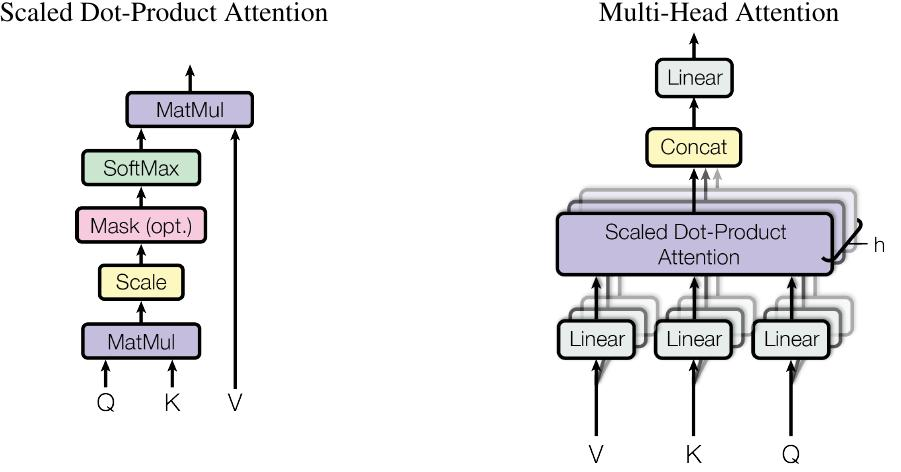

In [ ]:
display_base64_image(images[1])

In [ ]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

## RAG pipeline

In [ ]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)

In [ ]:
response = chain.invoke(
    "What BLEU score for model ByteNet"
)

print(response)

The BLEU score for the model ByteNet is 23.75.


Response: The attention mechanism is a crucial concept in machine learning, particularly within natural language processing and neural networks. It helps models focus on specific parts of the input when making predictions or generating outputs.

**Explanation:**

1. **Scaled Dot-Product Attention**: At the core of the attention mechanism, we calculate the dot products of the query (Q) with all keys (K), scale the result, apply a softmax function to obtain attention weights, and then perform a weighted sum of the values (V). This allows the model to attend to relevant parts of the input data.

2. **Multi-Head Attention**: To capture different relationships, multiple sets of Q, K, and V (referred to as "heads") are processed in parallel. Each head learns to focus on different aspects of the input.

3. **Linear Transformations**: Inputs undergo linear transformations (represented in the diagrams as "Linear") before being fed into the attention mechanism, allowing for dimensionality adjust

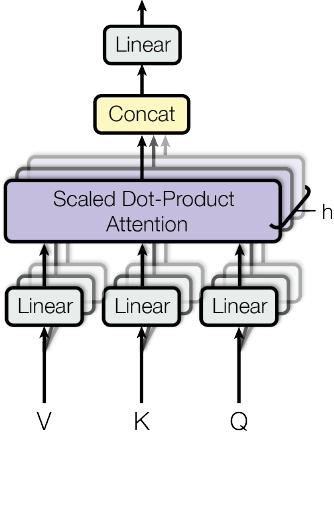

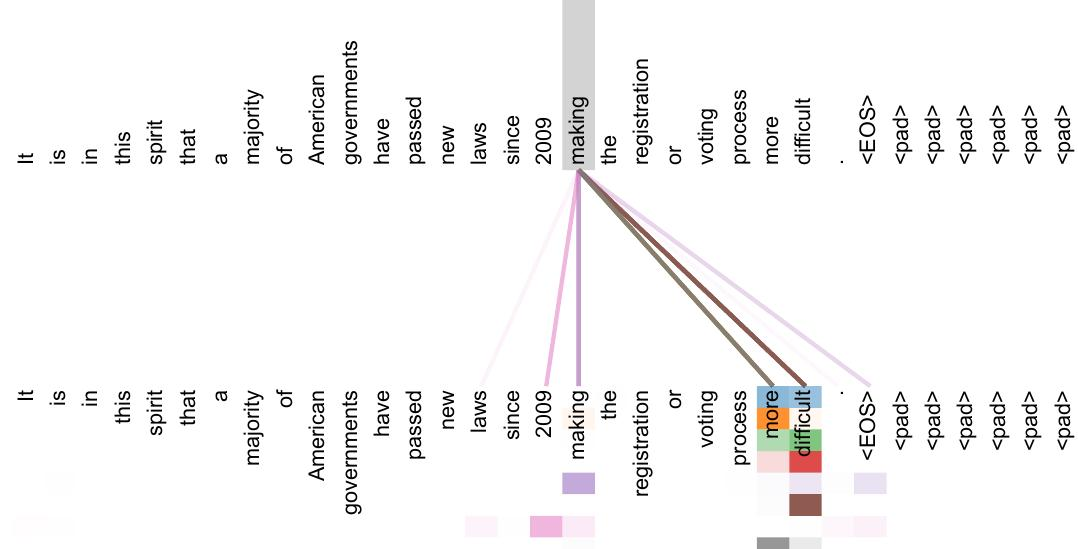

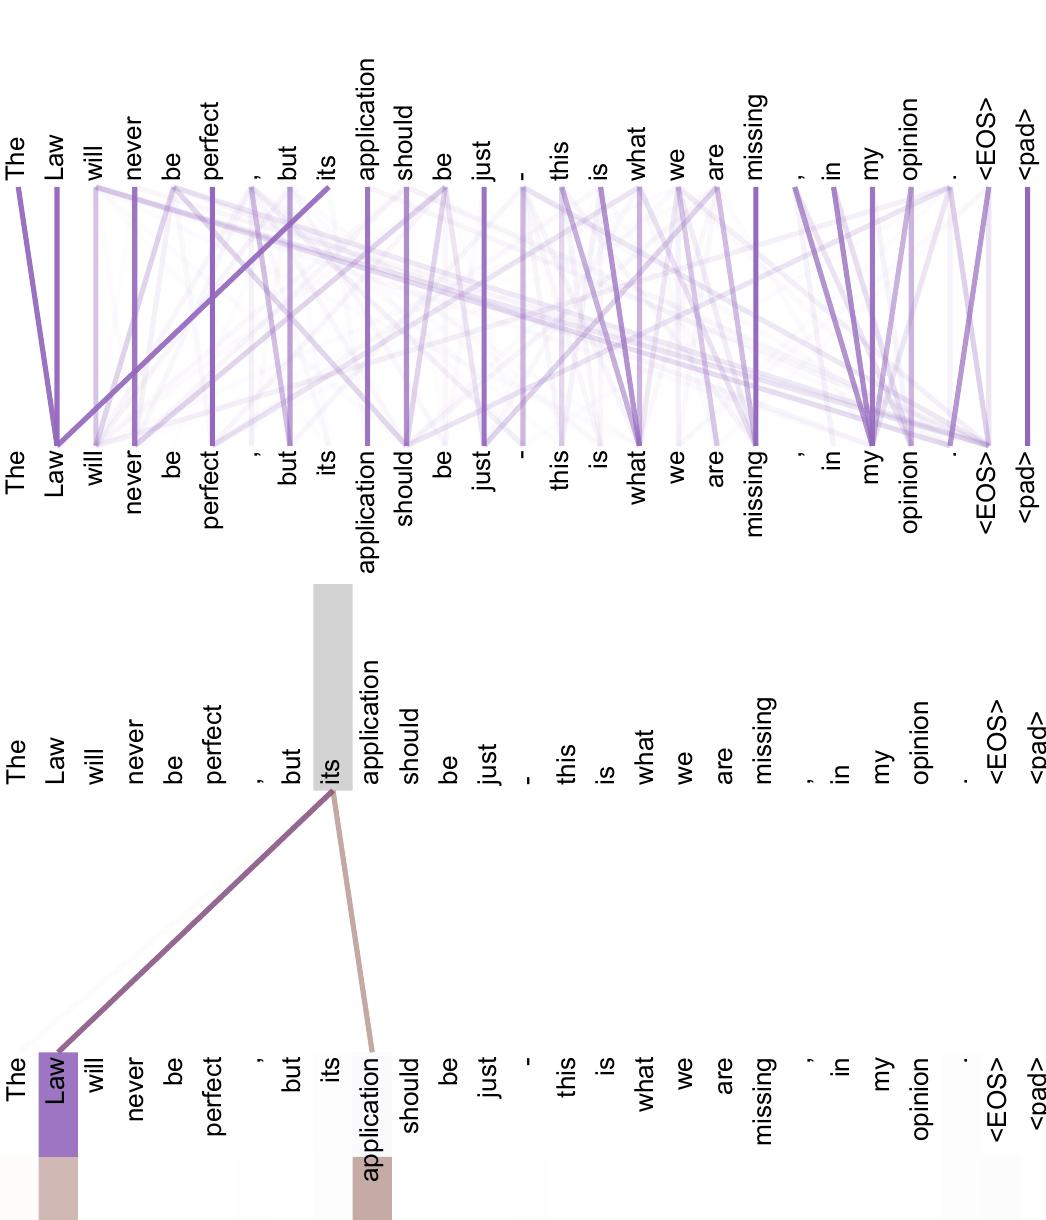

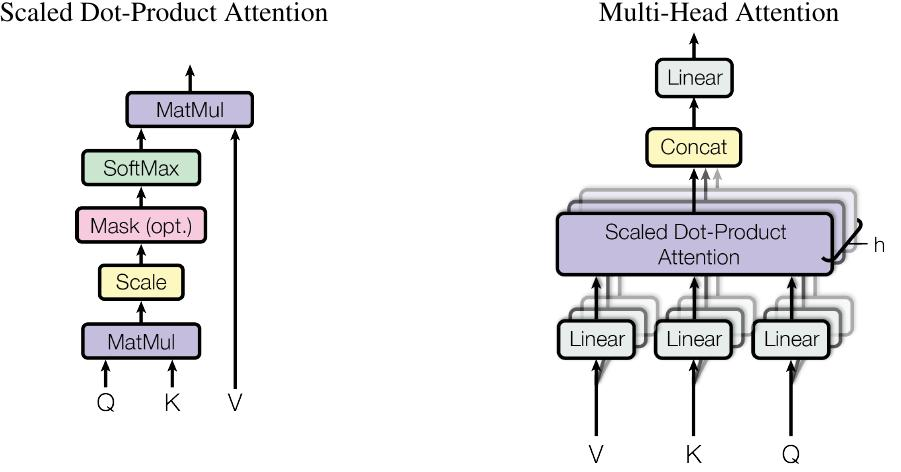

In [ ]:
response = chain_with_sources.invoke(
    "What is attention mechanism, explain with image"
)

print("Response:", response['response'])

#print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

## References

- [LangChain Inspiration](https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_structured_and_multi_modal_RAG.ipynb?ref=blog.langchain.dev)
- [Multivector Storage](https://python.langchain.com/docs/how_to/multi_vector/)